# Data Preparation

In [5]:
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from numpy import savez_compressed
 
# load all images in a directory into memory
def load_images(path, size=(256,512)):
 src_list, tar_list = list(), list()
 # enumerate filenames in directory, assume all are images
 for filename in listdir(path):
     # load and resize the image
     pixels = load_img(path + filename, target_size=size)
     # convert to numpy array
     pixels = img_to_array(pixels)
     # split into satellite and map
     sat_img, map_img = pixels[:, :256], pixels[:, 256:]
     src_list.append(sat_img)
     tar_list.append(map_img)
 return [asarray(src_list), asarray(tar_list)]
 
# dataset path
path = 'maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)
Saved dataset:  maps_256.npz


Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


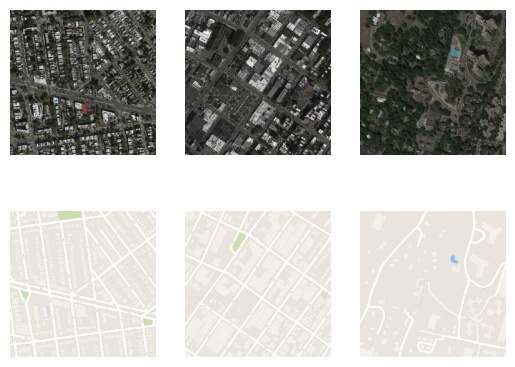

In [6]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + i)
 pyplot.axis('off')
 pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + n_samples + i)
 pyplot.axis('off')
 pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
 # weight initialization
 init = RandomNormal(stddev=0.02, seed=0)
 # source image input
 in_src_image = Input(shape=image_shape)
 # target image input
 in_target_image = Input(shape=image_shape)
 # concatenate images channel-wise
 merged = Concatenate()([in_src_image, in_target_image])
 # C64
 d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
 d = LeakyReLU(alpha=0.2)(d)
 # C128
 d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # C256
 d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # C512
 d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # second last output layer
 d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # patch output
 d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
 patch_out = Activation('sigmoid')(d)
 # define model
 model = Model([in_src_image, in_target_image], patch_out)
 # compile model
 opt = Adam(learning_rate=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
 return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
 # weight initialization
 init = RandomNormal(stddev=0.02, seed=0)
 # add downsampling layer
 g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
 # conditionally add batch normalization
 if batchnorm:
     g = BatchNormalization()(g, training=True)
     # leaky relu activation
     g = LeakyReLU(alpha=0.2)(g)
 return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
 # weight initialization
 init = RandomNormal(stddev=0.02, seed=0)
 # add upsampling layer
 g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
 # add batch normalization
 g = BatchNormalization()(g, training=True)
 # conditionally add dropout
 if dropout:
     g = Dropout(0.5)(g, training=True)
     # merge with skip connection
     g = Concatenate()([g, skip_in])
     # relu activation
     g = Activation('relu')(g)
 return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
 # weight initialization
 init = RandomNormal(stddev=0.02, seed=0)
 # image input
 in_image = Input(shape=image_shape)
 # encoder model
 e1 = define_encoder_block(in_image, 64, batchnorm=False)
 e2 = define_encoder_block(e1, 128)
 e3 = define_encoder_block(e2, 256)
 e4 = define_encoder_block(e3, 512)
 e5 = define_encoder_block(e4, 512)
 e6 = define_encoder_block(e5, 512)
 e7 = define_encoder_block(e6, 512)
 # bottleneck, no batch norm and relu
 b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
 b = Activation('relu')(b)
 # decoder model
 d1 = decoder_block(b, e7, 512)
 d2 = decoder_block(d1, e6, 512)
 d3 = decoder_block(d2, e5, 512)
 d4 = decoder_block(d3, e4, 512, dropout=False)
 d5 = decoder_block(d4, e3, 256, dropout=False)
 d6 = decoder_block(d5, e2, 128, dropout=False)
 d7 = decoder_block(d6, e1, 64, dropout=False)
 # output
 g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
 out_image = Activation('tanh')(g)
 # define model
 model = Model(in_image, out_image)
 return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
 # make weights in the discriminator not trainable
 for layer in d_model.layers:
     if not isinstance(layer, BatchNormalization):
         layer.trainable = False
         # define the source image
         in_src = Input(shape=image_shape)
         # connect the source image to the generator input
         gen_out = g_model(in_src)
         # connect the source input and generator output to the discriminator input
         dis_out = d_model([in_src, gen_out])
         # src image as input, generated image and classification output
         model = Model(in_src, [dis_out, gen_out])
         # compile model
         opt = Adam(learning_rate=0.0002, beta_1=0.5)
         model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
 return model

# load and prepare training images
def load_real_samples(filename):
 # load compressed arrays
 data = load(filename)
 # unpack arrays
 X1, X2 = data['arr_0'], data['arr_1']
 # scale from [0,255] to [-1,1]
 X1 = (X1 - 127.5) / 127.5
 X2 = (X2 - 127.5) / 127.5
 return [X2, X1]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
 # unpack dataset
 trainA, trainB = dataset
 # choose random instances
 ix = randint(0, trainA.shape[0], n_samples)
 # retrieve selected images
 X1, X2 = trainA[ix], trainB[ix]
 # generate 'real' class labels (1)
 y = ones((n_samples, patch_shape, patch_shape, 1))
 return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
 # generate fake instance
 X = g_model.predict(samples)
 # create 'fake' class labels (0)
 y = zeros((len(X), patch_shape, patch_shape, 1))
 return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
 # select a sample of input images
 [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
 # generate a batch of fake samples
 X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
 # scale all pixels from [-1,1] to [0,1]
 X_realA = (X_realA + 1) / 2.0
 X_realB = (X_realB + 1) / 2.0
 X_fakeB = (X_fakeB + 1) / 2.0
 # plot real source images
 for i in range(n_samples):
     pyplot.subplot(3, n_samples, 1 + i)
     pyplot.axis('off')
     pyplot.imshow(X_realA[i])
 # plot generated target image
 for i in range(n_samples):
     pyplot.subplot(3, n_samples, 1 + n_samples + i)
     pyplot.axis('off')
     pyplot.imshow(X_fakeB[i])
 # plot real target image
 for i in range(n_samples):
     pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
     pyplot.axis('off')
     pyplot.imshow(X_realB[i])
 # save plot to file
 filename1 = 'plot_%06d.png' % (step+1)
 pyplot.savefig(filename1)
 pyplot.close()
 # save the generator model
 filename2 = 'model_%06d.h5' % (step+1)
 g_model.save(filename2)
 print('>Saved: %s and %s' % (filename1, filename2))
    
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
 # determine the output square shape of the discriminator
 n_patch = d_model.output_shape[1]
 # unpack dataset
 trainA, trainB = dataset
 # calculate the number of batches per training epoch
 bat_per_epo = int(len(trainA) / n_batch)
 # calculate the number of training iterations
 n_steps = bat_per_epo * n_epochs
 # manually enumerate epochs
 for i in range(n_steps):
     # select a batch of real samples
     [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
     # generate a batch of fake samples
     X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
     # update discriminator for real samples
     d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
     # update discriminator for generated samples
     d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
     # update the generator
     g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
     # summarize performance
     print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
 # summarize model performance
 if (i+1) % (bat_per_epo * 10) == 0:
     summarize_performance(i, g_model, dataset)

# load image data
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset, n_epochs=2)
# to run the entire dataset, n_epochs should be deleted

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)
1/1 [==============================] - 2s 2s/step
>1, d1[0.450] d2[0.650] g[57.143]
1/1 [==============================] - 1s 612ms/step
>2, d1[0.522] d2[0.864] g[57.316]
1/1 [==============================] - 1s 619ms/step
>3, d1[0.419] d2[0.536] g[58.506]
1/1 [==============================] - 1s 605ms/step
>4, d1[0.459] d2[0.476] g[53.464]
1/1 [==============================] - 1s 623ms/step
>5, d1[0.367] d2[0.532] g[60.181]
1/1 [==============================] - 1s 634ms/step
>6, d1[0.381] d2[0.524] g[53.094]
1/1 [==============================] - 1s 601ms/step
>7, d1[0.378] d2[0.583] g[63.730]
1/1 [==============================] - 1s 606ms/step
>8, d1[0.189] d2[0.429] g[70.398]
1/1 [==============================] - 1s 602ms/step
>9, d1[0.462] d2[1.097] g[68.027]
1/1 [==============================] - 1s 588ms/step
>10, d1[0.478] d2[0.595] g[59.076]
1/1 [==============================] - 1s 617ms/step
>11, d1[0.407] d2[0.443] g[52.30

1/1 [==============================] - 1s 628ms/step
>94, d1[0.001] d2[0.005] g[32.041]
1/1 [==============================] - 1s 615ms/step
>95, d1[0.002] d2[0.006] g[33.372]
1/1 [==============================] - 1s 646ms/step
>96, d1[0.004] d2[0.006] g[41.320]
1/1 [==============================] - 1s 647ms/step
>97, d1[0.004] d2[0.005] g[40.931]
1/1 [==============================] - 1s 629ms/step
>98, d1[0.004] d2[0.005] g[35.749]
1/1 [==============================] - 1s 628ms/step
>99, d1[0.002] d2[0.005] g[33.379]
1/1 [==============================] - 1s 628ms/step
>100, d1[0.005] d2[0.005] g[38.845]
1/1 [==============================] - 1s 622ms/step
>101, d1[0.043] d2[0.007] g[39.322]
1/1 [==============================] - 1s 612ms/step
>102, d1[0.006] d2[0.014] g[43.681]
1/1 [==============================] - 1s 627ms/step
>103, d1[0.002] d2[0.011] g[36.132]
1/1 [==============================] - 1s 629ms/step
>104, d1[0.003] d2[0.008] g[35.921]
1/1 [======================

1/1 [==============================] - 1s 643ms/step
>186, d1[0.001] d2[0.002] g[33.894]
1/1 [==============================] - 1s 642ms/step
>187, d1[0.003] d2[0.003] g[31.797]
1/1 [==============================] - 1s 625ms/step
>188, d1[0.001] d2[0.003] g[35.850]
1/1 [==============================] - 1s 660ms/step
>189, d1[0.002] d2[0.002] g[41.732]
1/1 [==============================] - 1s 648ms/step
>190, d1[0.002] d2[0.002] g[38.711]
1/1 [==============================] - 1s 753ms/step
>191, d1[0.002] d2[0.002] g[41.697]
1/1 [==============================] - 1s 633ms/step
>192, d1[0.003] d2[0.002] g[45.938]
1/1 [==============================] - 1s 638ms/step
>193, d1[0.001] d2[0.002] g[31.904]
1/1 [==============================] - 1s 639ms/step
>194, d1[0.002] d2[0.002] g[43.327]
1/1 [==============================] - 1s 631ms/step
>195, d1[0.003] d2[0.002] g[48.955]
1/1 [==============================] - 1s 641ms/step
>196, d1[0.001] d2[0.003] g[30.397]
1/1 [================

1/1 [==============================] - 1s 636ms/step
>278, d1[0.001] d2[0.002] g[33.646]
1/1 [==============================] - 1s 670ms/step
>279, d1[0.001] d2[0.002] g[31.469]
1/1 [==============================] - 1s 639ms/step
>280, d1[0.001] d2[0.002] g[36.509]
1/1 [==============================] - 1s 655ms/step
>281, d1[0.000] d2[0.002] g[35.758]
1/1 [==============================] - 1s 641ms/step
>282, d1[0.001] d2[0.002] g[38.183]
1/1 [==============================] - 1s 643ms/step
>283, d1[0.001] d2[0.002] g[40.267]
1/1 [==============================] - 1s 635ms/step
>284, d1[0.001] d2[0.002] g[35.064]
1/1 [==============================] - 1s 640ms/step
>285, d1[0.001] d2[0.002] g[34.192]
1/1 [==============================] - 1s 624ms/step
>286, d1[0.001] d2[0.002] g[36.333]
1/1 [==============================] - 1s 633ms/step
>287, d1[0.001] d2[0.002] g[32.680]
1/1 [==============================] - 1s 624ms/step
>288, d1[0.001] d2[0.002] g[34.380]
1/1 [================

1/1 [==============================] - 1s 636ms/step
>370, d1[0.000] d2[0.002] g[24.648]
1/1 [==============================] - 1s 671ms/step
>371, d1[0.000] d2[0.002] g[35.282]
1/1 [==============================] - 1s 635ms/step
>372, d1[0.000] d2[0.001] g[26.014]
1/1 [==============================] - 1s 642ms/step
>373, d1[0.000] d2[0.001] g[29.761]
1/1 [==============================] - 1s 643ms/step
>374, d1[0.000] d2[0.002] g[33.312]
1/1 [==============================] - 1s 623ms/step
>375, d1[0.000] d2[0.002] g[33.156]
1/1 [==============================] - 1s 623ms/step
>376, d1[0.001] d2[0.001] g[43.596]
1/1 [==============================] - 1s 624ms/step
>377, d1[0.000] d2[0.002] g[29.509]
1/1 [==============================] - 1s 624ms/step
>378, d1[0.045] d2[2.251] g[27.216]
1/1 [==============================] - 1s 639ms/step
>379, d1[1.215] d2[0.036] g[36.569]
1/1 [==============================] - 1s 624ms/step
>380, d1[0.756] d2[0.022] g[40.681]
1/1 [================

1/1 [==============================] - 1s 1s/step
>464, d1[0.004] d2[0.008] g[38.396]
1/1 [==============================] - 1s 1s/step
>465, d1[0.006] d2[0.008] g[46.148]
1/1 [==============================] - 1s 1s/step
>466, d1[0.002] d2[0.008] g[29.504]
1/1 [==============================] - 1s 1s/step
>467, d1[0.006] d2[0.007] g[32.312]
1/1 [==============================] - 1s 1s/step
>468, d1[0.002] d2[0.007] g[31.317]
1/1 [==============================] - 2s 2s/step
>469, d1[0.002] d2[0.007] g[25.592]
1/1 [==============================] - 1s 1s/step
>470, d1[0.003] d2[0.007] g[29.639]
1/1 [==============================] - 1s 1s/step
>471, d1[0.000] d2[0.007] g[25.201]
1/1 [==============================] - 1s 1s/step
>472, d1[0.009] d2[0.019] g[37.237]
1/1 [==============================] - 1s 1s/step
>473, d1[0.001] d2[0.010] g[21.280]
1/1 [==============================] - 1s 874ms/step
>474, d1[0.003] d2[0.010] g[32.642]
1/1 [==============================] - 1s 696ms/ste

1/1 [==============================] - 1s 778ms/step
>558, d1[0.003] d2[0.004] g[23.757]
1/1 [==============================] - 1s 641ms/step
>559, d1[0.001] d2[0.004] g[34.859]
1/1 [==============================] - 1s 616ms/step
>560, d1[0.002] d2[0.004] g[44.117]
1/1 [==============================] - 1s 1s/step
>561, d1[0.002] d2[0.004] g[40.403]
1/1 [==============================] - 1s 1s/step
>562, d1[0.001] d2[0.004] g[32.333]
1/1 [==============================] - 1s 625ms/step
>563, d1[0.001] d2[0.004] g[31.830]
1/1 [==============================] - 1s 672ms/step
>564, d1[0.002] d2[0.004] g[38.490]
1/1 [==============================] - 1s 688ms/step
>565, d1[0.002] d2[0.004] g[41.044]
1/1 [==============================] - 1s 625ms/step
>566, d1[0.001] d2[0.004] g[34.532]
1/1 [==============================] - 1s 625ms/step
>567, d1[0.004] d2[0.004] g[42.557]
1/1 [==============================] - 1s 641ms/step
>568, d1[0.001] d2[0.004] g[38.067]
1/1 [======================

1/1 [==============================] - 1s 937ms/step
>650, d1[0.000] d2[0.003] g[37.076]
1/1 [==============================] - 1s 668ms/step
>651, d1[0.001] d2[0.003] g[41.521]
1/1 [==============================] - 1s 757ms/step
>652, d1[0.001] d2[0.003] g[37.016]
1/1 [==============================] - 1s 799ms/step
>653, d1[0.000] d2[0.003] g[28.906]
1/1 [==============================] - 1s 656ms/step
>654, d1[0.000] d2[0.003] g[31.252]
1/1 [==============================] - 1s 609ms/step
>655, d1[0.001] d2[0.003] g[36.012]
1/1 [==============================] - 1s 625ms/step
>656, d1[0.002] d2[0.003] g[44.607]
1/1 [==============================] - 1s 625ms/step
>657, d1[0.000] d2[0.003] g[37.261]
1/1 [==============================] - 1s 625ms/step
>658, d1[0.001] d2[0.003] g[40.172]
1/1 [==============================] - 1s 609ms/step
>659, d1[0.001] d2[0.003] g[35.357]
1/1 [==============================] - 1s 625ms/step
>660, d1[0.001] d2[0.003] g[33.863]
1/1 [================

1/1 [==============================] - 1s 950ms/step
>742, d1[0.002] d2[0.003] g[45.520]
1/1 [==============================] - 1s 861ms/step
>743, d1[0.002] d2[0.003] g[41.134]
1/1 [==============================] - 1s 763ms/step
>744, d1[0.001] d2[0.003] g[30.198]
1/1 [==============================] - 1s 1s/step
>745, d1[0.000] d2[0.003] g[34.325]
1/1 [==============================] - 1s 1s/step
>746, d1[0.005] d2[0.003] g[40.798]
1/1 [==============================] - 1s 1s/step
>747, d1[0.001] d2[0.003] g[36.996]
1/1 [==============================] - 1s 1s/step
>748, d1[0.002] d2[0.003] g[42.701]
1/1 [==============================] - 1s 656ms/step
>749, d1[0.000] d2[0.003] g[36.119]
1/1 [==============================] - 1s 764ms/step
>750, d1[0.001] d2[0.003] g[34.030]
1/1 [==============================] - 1s 609ms/step
>751, d1[0.000] d2[0.003] g[30.707]
1/1 [==============================] - 1s 659ms/step
>752, d1[0.001] d2[0.003] g[43.076]
1/1 [============================

1/1 [==============================] - 1s 641ms/step
>834, d1[0.000] d2[0.002] g[20.956]
1/1 [==============================] - 1s 641ms/step
>835, d1[0.000] d2[0.002] g[27.892]
1/1 [==============================] - 1s 767ms/step
>836, d1[0.000] d2[0.002] g[36.150]
1/1 [==============================] - 1s 676ms/step
>837, d1[0.000] d2[0.002] g[30.124]
1/1 [==============================] - 1s 672ms/step
>838, d1[0.002] d2[0.002] g[41.581]
1/1 [==============================] - 1s 656ms/step
>839, d1[0.001] d2[0.002] g[37.136]
1/1 [==============================] - 1s 738ms/step
>840, d1[0.000] d2[0.002] g[34.272]
1/1 [==============================] - 1s 688ms/step
>841, d1[0.000] d2[0.002] g[34.348]
1/1 [==============================] - 1s 656ms/step
>842, d1[0.000] d2[0.002] g[29.200]
1/1 [==============================] - 1s 952ms/step
>843, d1[0.000] d2[0.002] g[35.285]
1/1 [==============================] - 1s 673ms/step
>844, d1[0.000] d2[0.002] g[37.202]
1/1 [================

>926, d1[0.001] d2[0.003] g[39.181]
1/1 [==============================] - 1s 984ms/step
>927, d1[0.000] d2[0.003] g[32.926]
1/1 [==============================] - 1s 906ms/step
>928, d1[0.000] d2[0.003] g[28.432]
1/1 [==============================] - 1s 665ms/step
>929, d1[0.000] d2[0.003] g[39.554]
1/1 [==============================] - 1s 750ms/step
>930, d1[0.001] d2[0.002] g[33.830]
1/1 [==============================] - 1s 657ms/step
>931, d1[0.001] d2[0.002] g[31.101]
1/1 [==============================] - 1s 681ms/step
>932, d1[0.001] d2[0.002] g[33.008]
1/1 [==============================] - 1s 755ms/step
>933, d1[0.000] d2[0.002] g[36.708]
1/1 [==============================] - 1s 833ms/step
>934, d1[0.001] d2[0.002] g[38.720]
1/1 [==============================] - 1s 659ms/step
>935, d1[0.000] d2[0.002] g[28.604]
1/1 [==============================] - 1s 664ms/step
>936, d1[0.001] d2[0.002] g[41.045]
1/1 [==============================] - 1s 666ms/step
>937, d1[0.000] d2[0.

1/1 [==============================] - 1s 652ms/step
>1018, d1[0.000] d2[0.002] g[24.239]
1/1 [==============================] - 1s 661ms/step
>1019, d1[0.000] d2[0.002] g[26.430]
1/1 [==============================] - 1s 653ms/step
>1020, d1[0.000] d2[0.002] g[30.236]
1/1 [==============================] - 1s 644ms/step
>1021, d1[0.000] d2[0.002] g[35.587]
1/1 [==============================] - 1s 676ms/step
>1022, d1[0.000] d2[0.002] g[38.940]
1/1 [==============================] - 1s 675ms/step
>1023, d1[0.000] d2[0.002] g[32.071]
1/1 [==============================] - 1s 658ms/step
>1024, d1[0.001] d2[0.002] g[45.485]
1/1 [==============================] - 1s 658ms/step
>1025, d1[0.000] d2[0.002] g[36.294]
1/1 [==============================] - 1s 633ms/step
>1026, d1[0.000] d2[0.002] g[35.688]
1/1 [==============================] - 1s 654ms/step
>1027, d1[0.000] d2[0.002] g[40.624]
1/1 [==============================] - 1s 657ms/step
>1028, d1[0.000] d2[0.002] g[33.902]
1/1 [=====

1/1 [==============================] - 1s 891ms/step
>1109, d1[0.000] d2[0.002] g[31.294]
1/1 [==============================] - 1s 891ms/step
>1110, d1[0.000] d2[0.002] g[32.181]
1/1 [==============================] - 1s 891ms/step
>1111, d1[0.000] d2[0.002] g[32.562]
1/1 [==============================] - 1s 672ms/step
>1112, d1[0.000] d2[0.002] g[43.380]
1/1 [==============================] - 1s 656ms/step
>1113, d1[0.000] d2[0.002] g[22.681]
1/1 [==============================] - 1s 661ms/step
>1114, d1[0.000] d2[0.002] g[35.979]
1/1 [==============================] - 1s 944ms/step
>1115, d1[0.001] d2[0.002] g[40.785]
1/1 [==============================] - 1s 875ms/step
>1116, d1[0.000] d2[0.002] g[42.471]
1/1 [==============================] - 1s 797ms/step
>1117, d1[0.000] d2[0.002] g[32.066]
1/1 [==============================] - 1s 872ms/step
>1118, d1[0.000] d2[0.002] g[27.189]
1/1 [==============================] - 1s 904ms/step
>1119, d1[0.001] d2[0.002] g[31.245]
1/1 [=====

1/1 [==============================] - 1s 625ms/step
>1200, d1[0.000] d2[0.001] g[24.078]
1/1 [==============================] - 1s 656ms/step
>1201, d1[0.000] d2[0.002] g[42.800]
1/1 [==============================] - 1s 625ms/step
>1202, d1[0.000] d2[0.002] g[40.882]
1/1 [==============================] - 1s 641ms/step
>1203, d1[0.000] d2[0.002] g[29.714]
1/1 [==============================] - 1s 641ms/step
>1204, d1[0.000] d2[0.002] g[41.464]
1/1 [==============================] - 1s 656ms/step
>1205, d1[0.000] d2[0.002] g[35.893]
1/1 [==============================] - 1s 641ms/step
>1206, d1[0.000] d2[0.002] g[41.809]
1/1 [==============================] - 1s 641ms/step
>1207, d1[0.000] d2[0.001] g[36.730]
1/1 [==============================] - 1s 641ms/step
>1208, d1[0.000] d2[0.001] g[35.955]
1/1 [==============================] - 1s 641ms/step
>1209, d1[0.000] d2[0.001] g[30.543]
1/1 [==============================] - 1s 656ms/step
>1210, d1[0.000] d2[0.002] g[33.991]
1/1 [=====

1/1 [==============================] - 1s 641ms/step
>1291, d1[0.002] d2[0.003] g[39.421]
1/1 [==============================] - 1s 641ms/step
>1292, d1[0.003] d2[0.003] g[39.406]
1/1 [==============================] - 1s 609ms/step
>1293, d1[0.000] d2[0.003] g[33.803]
1/1 [==============================] - 1s 625ms/step
>1294, d1[0.000] d2[0.003] g[30.566]
1/1 [==============================] - 1s 609ms/step
>1295, d1[0.001] d2[0.003] g[22.304]
1/1 [==============================] - 1s 609ms/step
>1296, d1[0.000] d2[0.003] g[34.002]
1/1 [==============================] - 1s 625ms/step
>1297, d1[0.001] d2[0.003] g[30.282]
1/1 [==============================] - 1s 625ms/step
>1298, d1[0.002] d2[0.003] g[25.078]
1/1 [==============================] - 1s 766ms/step
>1299, d1[0.003] d2[0.003] g[44.203]
1/1 [==============================] - 1s 625ms/step
>1300, d1[0.001] d2[0.003] g[40.307]
1/1 [==============================] - 1s 625ms/step
>1301, d1[0.000] d2[0.003] g[28.622]
1/1 [=====

1/1 [==============================] - 1s 641ms/step
>1382, d1[0.000] d2[0.002] g[27.462]
1/1 [==============================] - 1s 625ms/step
>1383, d1[0.000] d2[0.002] g[28.606]
1/1 [==============================] - 1s 625ms/step
>1384, d1[0.000] d2[0.002] g[33.001]
1/1 [==============================] - 1s 625ms/step
>1385, d1[0.000] d2[0.002] g[33.202]
1/1 [==============================] - 1s 625ms/step
>1386, d1[0.000] d2[0.002] g[37.203]
1/1 [==============================] - 1s 641ms/step
>1387, d1[0.000] d2[0.002] g[39.546]
1/1 [==============================] - 1s 625ms/step
>1388, d1[0.001] d2[0.002] g[27.257]
1/1 [==============================] - 1s 625ms/step
>1389, d1[0.000] d2[0.002] g[31.386]
1/1 [==============================] - 1s 641ms/step
>1390, d1[0.000] d2[0.002] g[35.933]
1/1 [==============================] - 1s 656ms/step
>1391, d1[0.000] d2[0.002] g[39.376]
1/1 [==============================] - 1s 656ms/step
>1392, d1[0.000] d2[0.002] g[28.144]
1/1 [=====

1/1 [==============================] - 1s 625ms/step
>1473, d1[0.000] d2[0.827] g[61.952]
1/1 [==============================] - 1s 641ms/step
>1474, d1[0.594] d2[0.374] g[31.477]
1/1 [==============================] - 1s 641ms/step
>1475, d1[0.469] d2[0.062] g[33.989]
1/1 [==============================] - 1s 625ms/step
>1476, d1[0.056] d2[0.092] g[40.627]
1/1 [==============================] - 1s 609ms/step
>1477, d1[0.007] d2[0.043] g[36.816]
1/1 [==============================] - 1s 625ms/step
>1478, d1[0.032] d2[0.032] g[31.906]
1/1 [==============================] - 1s 625ms/step
>1479, d1[0.007] d2[0.024] g[37.660]
1/1 [==============================] - 1s 625ms/step
>1480, d1[0.070] d2[0.018] g[37.035]
1/1 [==============================] - 1s 625ms/step
>1481, d1[0.014] d2[0.025] g[31.312]
1/1 [==============================] - 1s 609ms/step
>1482, d1[0.005] d2[0.019] g[35.566]
1/1 [==============================] - 1s 625ms/step
>1483, d1[0.005] d2[0.015] g[33.462]
1/1 [=====

1/1 [==============================] - 1s 656ms/step
>1564, d1[0.000] d2[0.002] g[24.406]
1/1 [==============================] - 1s 625ms/step
>1565, d1[0.000] d2[0.002] g[36.949]
1/1 [==============================] - 1s 641ms/step
>1566, d1[0.001] d2[0.002] g[33.468]
1/1 [==============================] - 1s 641ms/step
>1567, d1[0.000] d2[0.002] g[30.215]
1/1 [==============================] - 1s 625ms/step
>1568, d1[0.004] d2[0.003] g[34.564]
1/1 [==============================] - 1s 672ms/step
>1569, d1[0.000] d2[0.002] g[29.006]
1/1 [==============================] - 1s 703ms/step
>1570, d1[0.001] d2[0.002] g[46.341]
1/1 [==============================] - 1s 656ms/step
>1571, d1[0.002] d2[0.002] g[43.622]
1/1 [==============================] - 1s 641ms/step
>1572, d1[0.002] d2[0.002] g[30.329]
1/1 [==============================] - 1s 641ms/step
>1573, d1[0.000] d2[0.002] g[32.150]
1/1 [==============================] - 1s 641ms/step
>1574, d1[0.000] d2[0.003] g[38.000]
1/1 [=====

1/1 [==============================] - 1s 656ms/step
>1655, d1[0.002] d2[0.002] g[34.924]
1/1 [==============================] - 1s 677ms/step
>1656, d1[0.000] d2[0.002] g[35.758]
1/1 [==============================] - 1s 625ms/step
>1657, d1[0.000] d2[0.002] g[23.751]
1/1 [==============================] - 1s 641ms/step
>1658, d1[0.000] d2[0.002] g[29.453]
1/1 [==============================] - 1s 625ms/step
>1659, d1[0.001] d2[0.002] g[34.869]
1/1 [==============================] - 1s 625ms/step
>1660, d1[0.000] d2[0.002] g[31.288]
1/1 [==============================] - 1s 625ms/step
>1661, d1[0.003] d2[0.002] g[29.727]
1/1 [==============================] - 1s 641ms/step
>1662, d1[0.000] d2[0.002] g[32.894]
1/1 [==============================] - 1s 641ms/step
>1663, d1[0.001] d2[0.003] g[42.360]
1/1 [==============================] - 1s 641ms/step
>1664, d1[0.000] d2[0.002] g[39.581]
1/1 [==============================] - 1s 625ms/step
>1665, d1[0.000] d2[0.002] g[35.126]
1/1 [=====

1/1 [==============================] - 1s 625ms/step
>1746, d1[0.000] d2[0.002] g[37.751]
1/1 [==============================] - 1s 641ms/step
>1747, d1[0.000] d2[0.002] g[33.519]
1/1 [==============================] - 1s 641ms/step
>1748, d1[0.000] d2[0.002] g[43.307]
1/1 [==============================] - 1s 641ms/step
>1749, d1[0.000] d2[0.002] g[29.187]
1/1 [==============================] - 1s 625ms/step
>1750, d1[0.000] d2[0.002] g[23.884]
1/1 [==============================] - 1s 672ms/step
>1751, d1[0.000] d2[0.002] g[40.353]
1/1 [==============================] - 1s 661ms/step
>1752, d1[0.000] d2[0.002] g[35.269]
1/1 [==============================] - 1s 691ms/step
>1753, d1[0.000] d2[0.002] g[33.371]
1/1 [==============================] - 1s 847ms/step
>1754, d1[0.000] d2[0.002] g[32.866]
1/1 [==============================] - 1s 661ms/step
>1755, d1[0.000] d2[0.002] g[35.034]
1/1 [==============================] - 1s 907ms/step
>1756, d1[0.000] d2[0.002] g[29.764]
1/1 [=====

In [4]:
summarize_performance(2192, g_model, dataset)

1/1 [==============================] - 3s 3s/step
>Saved: plot_002193.png and model_002193.h5


# Standalone Map Translation

Loaded (1, 256, 256, 3)
1/1 [==============================] - 1s 1s/step


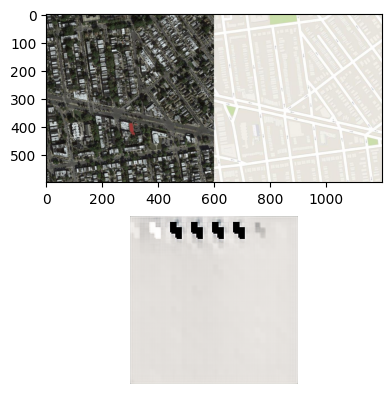

In [4]:
# example of loading a pix2pix model and using it for one-off image translation
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from numpy import load
from numpy import expand_dims
from matplotlib import pyplot

# load an image
def load_image(filename, size=(256, 256)):
    # load image with the preferred size
    pixels = load_img(filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # scale from [0,255] to [-1,1]
    pixels = (pixels - 127.5) / 127.5
    # reshape to 1 sample
    pixels = expand_dims(pixels, 0)
    return pixels


# load source image
src_path = "./maps/train/1.jpg"
src_image = load_image(src_path)
print('Loaded', src_image.shape)
pyplot.subplot(2, 1, 1)
pyplot.imshow(load_img(src_path))
# load model
model = load_model('model_002193.h5')
# generate image from source
gen_image = model.predict(src_image)
# scale from [-1,1] to [0,1]
gen_image = (gen_image + 1) / 2.0
# plot the image
pyplot.subplot(2, 1, 2)
pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show()